# Višeklasna klasifikacija korišćenjem neuronskih mreža

Zadatak:
* dizajnirati i natrenirati klasfikator koji slici cifre pridružuje cifru koja se na njoj nalazi.
* skup podataka: MNIST skup slika cifara
* dizajn resenja: koristićti neuronsku mrežu sa propagacijom unapred

Disclaimer: već na narednim vežbama, u istom zadatku klasifikacije slika, uvešćemo konvolutivne neuronske mreže koje predstavlju prirodniji izbor za resavanje ovog problema.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split

In [3]:
RANDOM_STATE = 1219
N_EPOCHS = 50
BATCH_SIZE_TRAIN = 1024
BATCH_SIZE_TEST = 1000
np.random.seed(RANDOM_STATE)

In [4]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def bind_gpu(data):
  device = get_device()
  if isinstance(data, (list, tuple)):
    return [bind_gpu(data_elem) for data_elem in data]
  else:
    return data.to(device, non_blocking=True)

In [5]:
print(get_device())

cuda


## Dataset

MNIST je skup podataka koji sadrži slike rukom pisanih cifara. Slika ima ukupno 70.000 od čega se obično 60.000 slika koristi za treniranje, a preostalih 10.000 za testiranje. Sve slike u skupu podataka su dimenzije 28px x 28px i u crno-belom su modu. Više o MNIST skupu podataka, kao i rezultatima dobijenim prvim algoritmima mašinskog učenja, možete pročitati [ovde](http://yann.lecun.com/exdb/mnist/).

In [6]:
from torchvision import datasets, transforms
from torch import utils

norm_mean = 0
norm_stddev = 1

train_loader = utils.data.DataLoader(
    datasets.MNIST('/files/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((norm_mean,), (norm_stddev,))
                       ])),
    batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_loader = utils.data.DataLoader(
    datasets.MNIST('/files/', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((norm_mean,), (norm_stddev,))
                       ])),
    batch_size=BATCH_SIZE_TEST, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12685585.10it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 343474.89it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1120924.72it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4132435.74it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [7]:
print(len(train_loader.dataset), len(test_loader.dataset))

60000 10000


In [8]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
batch_idx, example_data.shape, example_targets.shape

(0, torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

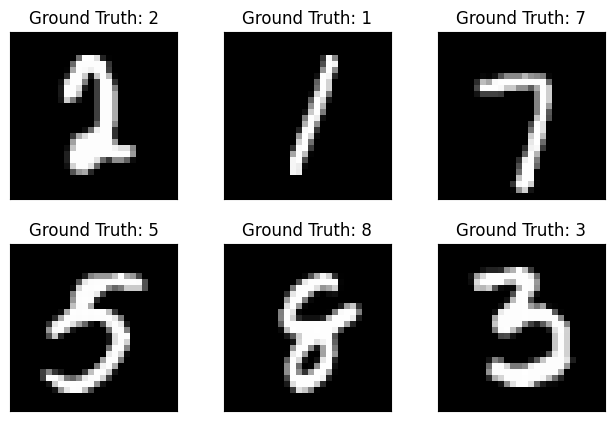

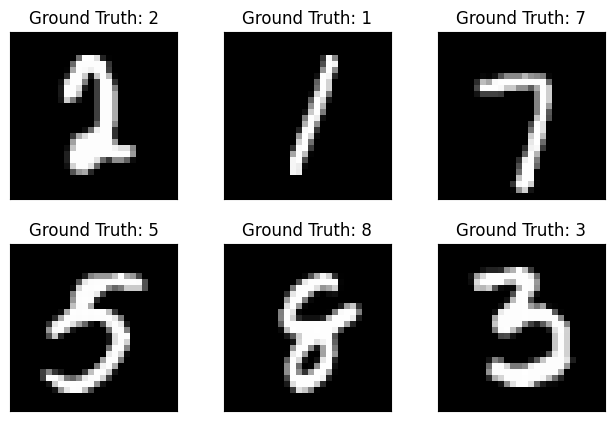

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [10]:
# for example, print 7-th instance
i = 5
print(example_data[i].shape, example_data[i][0].shape, example_data[i][0][0], example_targets[i])

torch.Size([1, 28, 28]) torch.Size([28, 28]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]) tensor(3)


## Dizjan Neuronske Mreze


Na slici je prikazana arhitekture mreže koju ćemo kreirati.

<img src="assets/mlp_mnist.png" />

#### Ulazni sloj

Ulaz u mrežu je "ispravljena" slika dimenzije 784 piksela.

<img src="assets/mnist-input.png" />


#### Skriveni slojevi

Mreža ima dva skrivena sloja, jedan dimenzije 128 neurona i drugi dimenzije 64 neurona. Oba sloja kao aktivaciju koriste *ReLu* funkciju.



#### Izlazni sloj

Izlazni sloj mreže ima 10 neurona. Svaki od njih odgovara jednoj od cifara od 0 do 9. Ideja je da vrednosti izlaza predstavljaju verovatnoće pripadanja odgovarajućoj klasi cifara. Preciznije, ako se za ulaz *img* koji predstavlja sliku dobija izlaz oblika $(v_0, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9)$ rezultat tj. klasa pripadanja će biti ona vrednost $i$ za koju je $v_i$ maksimalno. Na primer, ako $v_4$ ima najveću vrednost, onda zaključujemo da slika *img*  predstavlja broj 4.

Zato ćemo u poslednjem sloju mreže kao aktivacionu funkciju iskoristiti funkciju mekog maksimuma (engl. softmax) koja vrednost $v_i$ mapira u vrednost $\frac{e^{v_i}}{\sum_j{e^{v_j}}}$

In [11]:
import torch
import torch.nn as nn

class MNISTClassifier(nn.Module):
    def __init__(self, image_size, number_of_classes):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()  # Convert 2D image to 1D tensor
        self.fc1 = nn.Linear(image_size * image_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, number_of_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

## Trening Neuronske Mreze

U zadacima višeklasne klasifikacije, uz aktivaciju mekog maksimuma u zadanjem sloju, obično se kao funkcija gubitka koristi `kategorička unakrsna entropija` (engl. categorical crossentropy). Ona predstavlja uopštenje binarne unakrsne entropije i računa se po formuli $-\sum_i{y_i \cdot log(\hat{y_i})}$ u kojoj $\hat{y_i}$ predstavlja predikciju mreže za instacu $i$, a $y_i$ njenu stvarnu vrednost.

Kao optimizator ćemo koristiti `Adam`.

Pratićemo tačnost kao relevantnu metriku za ocenu klasifikacije.

In [13]:
img_size = 28
number_of_classes = 10

model = MNISTClassifier(img_size, number_of_classes)
model = model.to(get_device())

In [14]:
def count_parameters(model):
  total_params = sum(p.numel() for p in model.parameters())

  # Iterate through the layers and print their details
  for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

  return total_params

In [15]:
count_parameters(model)

Layer: flatten, Parameters: 0
Layer: fc1, Parameters: 100480
Layer: relu, Parameters: 0
Layer: fc2, Parameters: 8256
Layer: fc3, Parameters: 650
Layer: softmax, Parameters: 0


109386

In [16]:
def train_classification(model, criterion, optimizer, number_of_epochs, train_loader, multiclass=False):
  losses = []
  accuracies = []
  device = get_device()

  for epoch in range(number_of_epochs):
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          if multiclass:
            predicted = torch.argmax(outputs, dim=1)
          else:
            predicted = (outputs > 0.5).float()
          correct += (predicted.squeeze() == labels).sum().item()
          total += labels.size(0)

      epoch_loss = running_loss / len(train_loader)
      epoch_accuracy = correct / total
      losses.append(epoch_loss)
      accuracies.append(epoch_accuracy)
      print(f"Epoch [{epoch + 1}/{number_of_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

  return losses, accuracies

In [17]:
%%time

import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

losses, accuracies = train_classification(model, criterion, optimizer, N_EPOCHS, train_loader, multiclass=True)

Epoch [1/50], Loss: 1.9680, Accuracy: 0.6077
Epoch [2/50], Loss: 1.6021, Accuracy: 0.8840
Epoch [3/50], Loss: 1.5633, Accuracy: 0.9112
Epoch [4/50], Loss: 1.5489, Accuracy: 0.9222
Epoch [5/50], Loss: 1.5398, Accuracy: 0.9302
Epoch [6/50], Loss: 1.5333, Accuracy: 0.9343
Epoch [7/50], Loss: 1.5278, Accuracy: 0.9398
Epoch [8/50], Loss: 1.5233, Accuracy: 0.9440
Epoch [9/50], Loss: 1.5199, Accuracy: 0.9467
Epoch [10/50], Loss: 1.5171, Accuracy: 0.9490
Epoch [11/50], Loss: 1.5134, Accuracy: 0.9522
Epoch [12/50], Loss: 1.5102, Accuracy: 0.9554
Epoch [13/50], Loss: 1.5082, Accuracy: 0.9572
Epoch [14/50], Loss: 1.5060, Accuracy: 0.9588
Epoch [15/50], Loss: 1.5040, Accuracy: 0.9608
Epoch [16/50], Loss: 1.5021, Accuracy: 0.9627
Epoch [17/50], Loss: 1.5002, Accuracy: 0.9643
Epoch [18/50], Loss: 1.4989, Accuracy: 0.9659
Epoch [19/50], Loss: 1.4973, Accuracy: 0.9677
Epoch [20/50], Loss: 1.4960, Accuracy: 0.9682
Epoch [21/50], Loss: 1.4941, Accuracy: 0.9701
Epoch [22/50], Loss: 1.4928, Accuracy: 0.97

In [18]:
def plot_classification(loss, accuracy, loss_title='Training Loss', accuracy_title='Training Accuracy'):
  number_of_epochs = len(loss)

  plt.title(loss_title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(range(number_of_epochs), loss)
  plt.show()

  plt.title(accuracy_title)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(range(number_of_epochs), accuracy)
  plt.show()

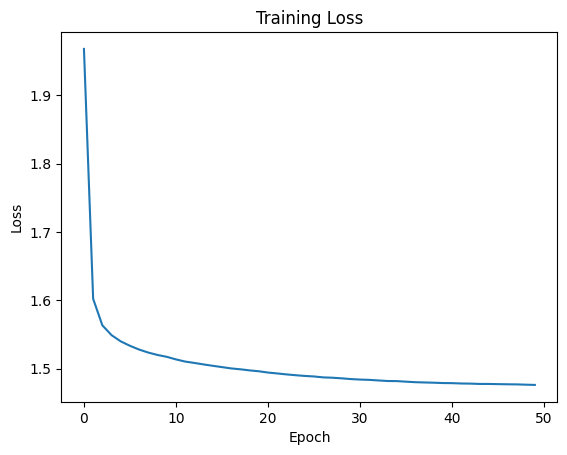

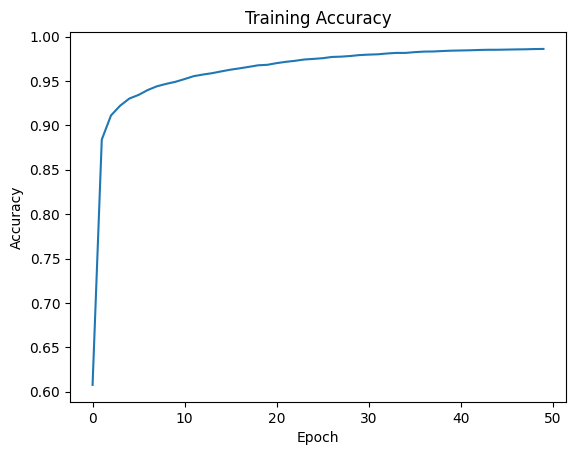

In [19]:
plot_classification(losses, accuracies)

In [20]:
def evaluate_classification(model, criterion, loader, multiclass=False):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    predicted_labels, true_labels = [], []
    device = get_device()

    with torch.no_grad():  # No gradient computation during evaluation
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_loss += criterion(outputs.squeeze(), labels).item()

            if multiclass:
              predicted = torch.argmax(outputs, dim=1)
            else:
              predicted = (outputs > 0.5).float()
            predicted_labels.extend(predicted.squeeze().tolist())
            true_labels.extend(labels.tolist())

            total_samples += labels.size(0)
            total_correct += (predicted.squeeze() == labels).sum().item()

    # compute metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    print(f'Model evaluation on: {loader}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # plot
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7cb212293b20>
Accuracy: 0.9862
Precision: 0.9862
Recall: 0.9862
F1 Score: 0.9862
Train Set: Loss: 1.4761, Accuracy: 0.9862


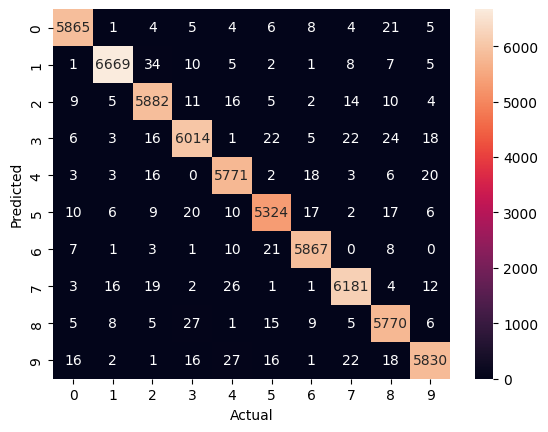

In [21]:
train_loss, train_accuracy = evaluate_classification(model, criterion, train_loader, True)
print(f'Train Set: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7cb212181c30>
Accuracy: 0.9698
Precision: 0.9698
Recall: 0.9698
F1 Score: 0.9698
Test Set: Loss: 1.4919, Accuracy: 0.9698


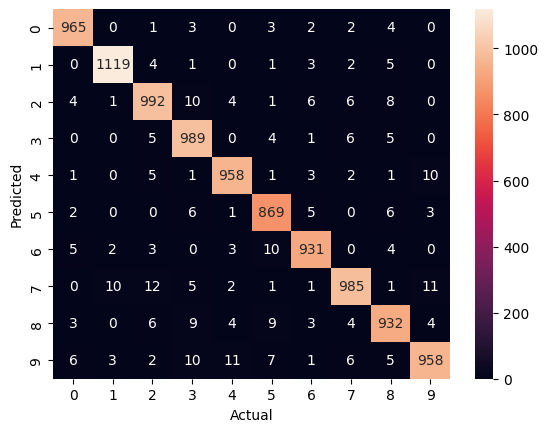

In [22]:
test_loss, test_accuracy = evaluate_classification(model, criterion, test_loader, True)
print(f'Test Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

## Trening Neuronske Mreze + Validation Split

In [23]:
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [24]:
data_dir = '/files/'
norm_mean = 0
norm_stddev = 1
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((norm_mean,), (norm_stddev,))
])

valid_size = 0.2
shuffle = True
num_workers = 1
pin_memory = True

In [25]:
train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
valid_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=train_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
  np.random.seed(RANDOM_STATE)
  np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, sampler=train_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE_TRAIN, sampler=valid_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, sampler=None,
                                           num_workers=num_workers, pin_memory=pin_memory)

In [26]:
def train_classification(model, criterion, optimizer, number_of_epochs, train_loader, validation_loader, multiclass=False):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    device = get_device()

    for epoch in range(number_of_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if multiclass:
              predicted = torch.argmax(outputs, dim=1)
            else:
              predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

        if validation_loader:
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for val_inputs, val_labels in validation_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs.squeeze(), val_labels)
                    val_running_loss += val_loss.item()

                    if multiclass:
                      val_predicted = torch.argmax(val_outputs, dim=1)
                    else:
                      val_predicted = (val_outputs > 0.5).float()
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted.squeeze() == val_labels).sum().item()

            epoch_val_loss = val_running_loss / len(validation_loader)
            epoch_val_accuracy = val_correct / val_total
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)
            print(f"Epoch [{epoch + 1}/{number_of_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

import matplotlib.pyplot as plt

def plot_classification(train_loss, train_accuracy, val_loss, val_accuracy):
    number_of_epochs = len(train_loss)
    epochs = range(1, number_of_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Training Loss
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epochs, train_loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Validation Loss')

    plt.legend()

    # Plotting Training Accuracy
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [27]:
%%time

model = MNISTClassifier(img_size, number_of_classes)
bind_gpu(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
epochs = 10

train_losses, train_accuracies, val_losses, val_accuracies = train_classification(model, criterion, optimizer, epochs, train_loader, valid_loader, True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Train Loss: 2.0229, Train Accuracy: 0.5388
Epoch [1/10], Validation Loss: 1.7242, Validation Accuracy: 0.7888
Epoch [2/10], Train Loss: 1.6652, Train Accuracy: 0.8208
Epoch [2/10], Validation Loss: 1.6392, Validation Accuracy: 0.8377
Epoch [3/10], Train Loss: 1.6278, Train Accuracy: 0.8441
Epoch [3/10], Validation Loss: 1.6251, Validation Accuracy: 0.8442
Epoch [4/10], Train Loss: 1.6170, Train Accuracy: 0.8512
Epoch [4/10], Validation Loss: 1.6185, Validation Accuracy: 0.8485
Epoch [5/10], Train Loss: 1.6100, Train Accuracy: 0.8571
Epoch [5/10], Validation Loss: 1.6134, Validation Accuracy: 0.8530
Epoch [6/10], Train Loss: 1.5789, Train Accuracy: 0.8919
Epoch [6/10], Validation Loss: 1.5509, Validation Accuracy: 0.9213
Epoch [7/10], Train Loss: 1.5413, Train Accuracy: 0.9290
Epoch [7/10], Validation Loss: 1.5387, Validation Accuracy: 0.9297
Epoch [8/10], Train Loss: 1.5328, Train Accuracy: 0.9362
Epoch [8/10], Validation Loss: 1.5331, Validation Accuracy: 0.9346
Epoch [9

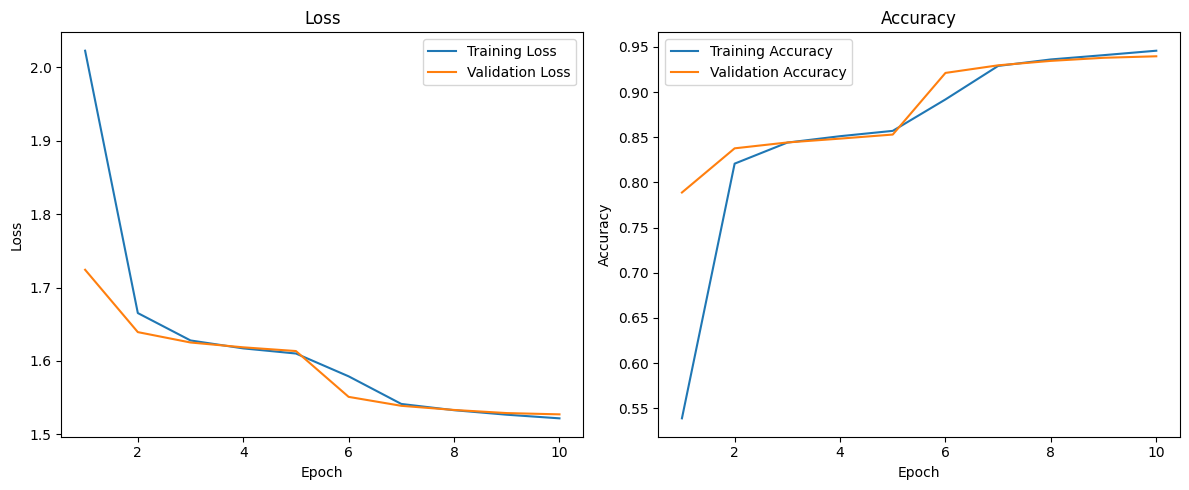

In [28]:
plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7cb1ecb120e0>
Accuracy: 0.9495
Precision: 0.9495
Recall: 0.9495
F1 Score: 0.9494
Train Set: Loss: 1.5182, Accuracy: 0.9495


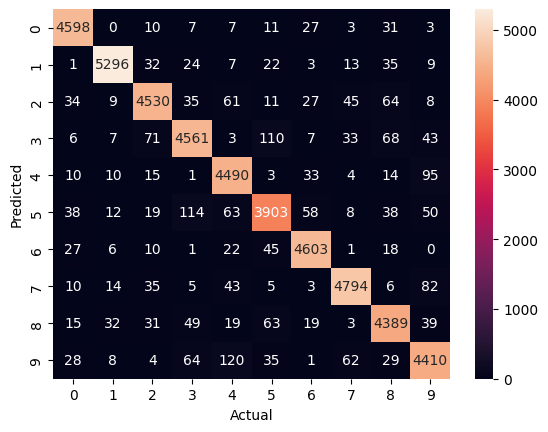

In [29]:
train_loss, train_accuracy = evaluate_classification(model, criterion, train_loader, True)
print(f'Train Set: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7cb1e52e3790>
Accuracy: 0.9398
Precision: 0.9398
Recall: 0.9398
F1 Score: 0.9397
Train Set: Loss: 1.5245, Accuracy: 0.9398


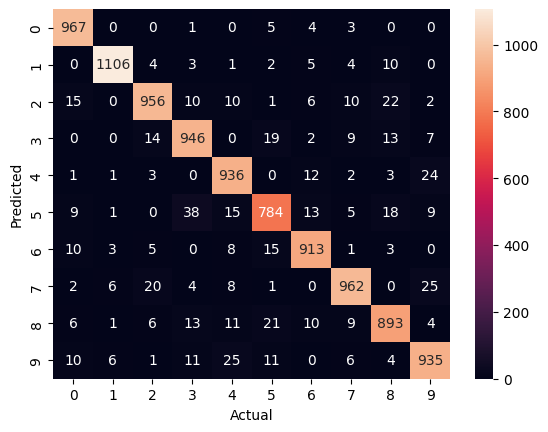

In [30]:
test_loss, test_accuracy = evaluate_classification(model, criterion, test_loader, True)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

## Trening Neuronske Mreze + L2

U opštem slučaju, prilikom analize tačnosti klasifikacije možemo se voditi zaključcima prikazanim na slici. <img src='assets/train_val_accuracy.png'>

Jedan način da se doda regularizacija modelu je uz korišćenje L2 regularizacije: https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch

In [31]:
# Training and plotting that uses validation data
def train_classification(model, criterion, optimizer, number_of_epochs, train_loader, validation_loader, multiclass=False):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    device = get_device()

    for epoch in range(number_of_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if multiclass:
              predicted = torch.argmax(outputs, dim=1)
            else:
              predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

        if validation_loader:
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for val_inputs, val_labels in validation_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs.squeeze(), val_labels)
                    val_running_loss += val_loss.item()

                    if multiclass:
                      val_predicted = torch.argmax(val_outputs, dim=1)
                    else:
                      val_predicted = (val_outputs > 0.5).float()
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted.squeeze() == val_labels).sum().item()

            epoch_val_loss = val_running_loss / len(validation_loader)
            epoch_val_accuracy = val_correct / val_total
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)
            print(f"Epoch [{epoch + 1}/{number_of_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [32]:
%%time

model = MNISTClassifier(img_size, number_of_classes)
bind_gpu(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=5e-4)

train_losses, train_accuracies, val_losses, val_accuracies = train_classification(model, criterion, optimizer, N_EPOCHS, train_loader, valid_loader, True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/50], Train Loss: 2.0575, Train Accuracy: 0.5107
Epoch [1/50], Validation Loss: 1.7706, Validation Accuracy: 0.7228
Epoch [2/50], Train Loss: 1.6570, Train Accuracy: 0.8538
Epoch [2/50], Validation Loss: 1.6003, Validation Accuracy: 0.8912
Epoch [3/50], Train Loss: 1.5829, Train Accuracy: 0.9009
Epoch [3/50], Validation Loss: 1.5730, Validation Accuracy: 0.9058
Epoch [4/50], Train Loss: 1.5657, Train Accuracy: 0.9136
Epoch [4/50], Validation Loss: 1.5630, Validation Accuracy: 0.9131
Epoch [5/50], Train Loss: 1.5573, Train Accuracy: 0.9196
Epoch [5/50], Validation Loss: 1.5561, Validation Accuracy: 0.9198
Epoch [6/50], Train Loss: 1.5515, Train Accuracy: 0.9245
Epoch [6/50], Validation Loss: 1.5513, Validation Accuracy: 0.9223
Epoch [7/50], Train Loss: 1.5463, Train Accuracy: 0.9290
Epoch [7/50], Validation Loss: 1.5462, Validation Accuracy: 0.9277
Epoch [8/50], Train Loss: 1.5413, Train Accuracy: 0.9330
Epoch [8/50], Validation Loss: 1.5425, Validation Accuracy: 0.9298
Epoch [9

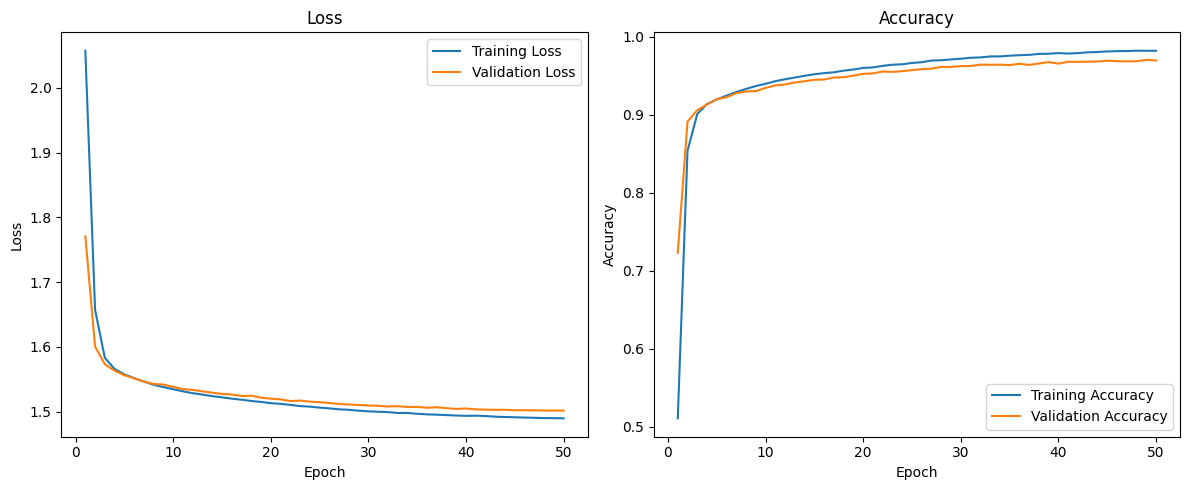

In [33]:
plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

Kao što možemo videti sada se situacija značajno popravila i naše krive se lepo prate.

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7cb1e52e3790>
Accuracy: 0.9721
Precision: 0.9722
Recall: 0.9721
F1 Score: 0.9721
Train Set: Loss: 1.4978, Accuracy: 0.9721


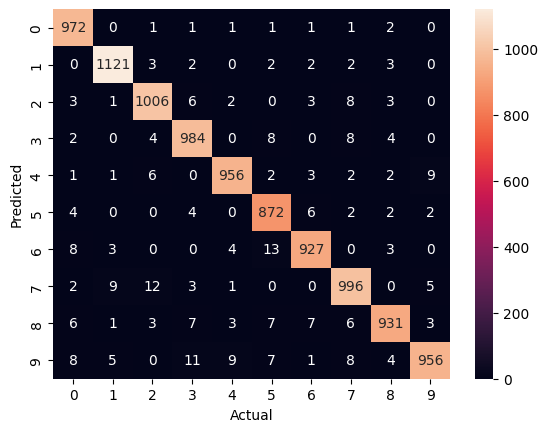

In [34]:
test_loss, test_accuracy = evaluate_classification(model, criterion, test_loader, True)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

## Trening Neuronske Mreze + Dropout

Zbog velikog broja parametara, regularizacije se gotovo pa neizostavno koriste u procesu obučavanja neuronskih mreža. Još jedna tehnika regularizacije je takozvana `dropout` regularizacija. Korišćenjem `dropout` regularizacije isključujemo nasumično odabrane neurone, omogućavamo drugačiji protok podataka kroz mrežu i smanjujemo zavisnosti izlaza od ulaza. Da bi se primenila ova tehnika regularizacije, dovoljno je mreži dodati `Dropout` sloj. Njegov parametar `rate` je verovatnoća isključivanja pojedinačnih neurona.
<img src='assets/dropout.png'>

In [35]:
import torch
import torch.nn as nn

class MNISTClassifier(nn.Module):
    def __init__(self, image_size, number_of_classes, dropout_prob=0.5):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(image_size * image_size, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)  # First dropout layer
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=dropout_prob)  # Second dropout layer
        self.fc3 = nn.Linear(64, number_of_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)  # Apply dropout after activation
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)  # Apply dropout after activation
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [36]:
%%time

model = MNISTClassifier(img_size, number_of_classes)
bind_gpu(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_losses, train_accuracies, val_losses, val_accuracies = train_classification(model, criterion, optimizer, N_EPOCHS, train_loader, valid_loader, True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/50], Train Loss: 2.1109, Train Accuracy: 0.4293
Epoch [1/50], Validation Loss: 1.8120, Validation Accuracy: 0.6952
Epoch [2/50], Train Loss: 1.7858, Train Accuracy: 0.7134
Epoch [2/50], Validation Loss: 1.6304, Validation Accuracy: 0.8578
Epoch [3/50], Train Loss: 1.6745, Train Accuracy: 0.8155
Epoch [3/50], Validation Loss: 1.5792, Validation Accuracy: 0.8973
Epoch [4/50], Train Loss: 1.6309, Train Accuracy: 0.8514
Epoch [4/50], Validation Loss: 1.5647, Validation Accuracy: 0.9041
Epoch [5/50], Train Loss: 1.6106, Train Accuracy: 0.8676
Epoch [5/50], Validation Loss: 1.5553, Validation Accuracy: 0.9116
Epoch [6/50], Train Loss: 1.5948, Train Accuracy: 0.8802
Epoch [6/50], Validation Loss: 1.5479, Validation Accuracy: 0.9193
Epoch [7/50], Train Loss: 1.5841, Train Accuracy: 0.8898
Epoch [7/50], Validation Loss: 1.5422, Validation Accuracy: 0.9230
Epoch [8/50], Train Loss: 1.5775, Train Accuracy: 0.8941
Epoch [8/50], Validation Loss: 1.5382, Validation Accuracy: 0.9267
Epoch [9

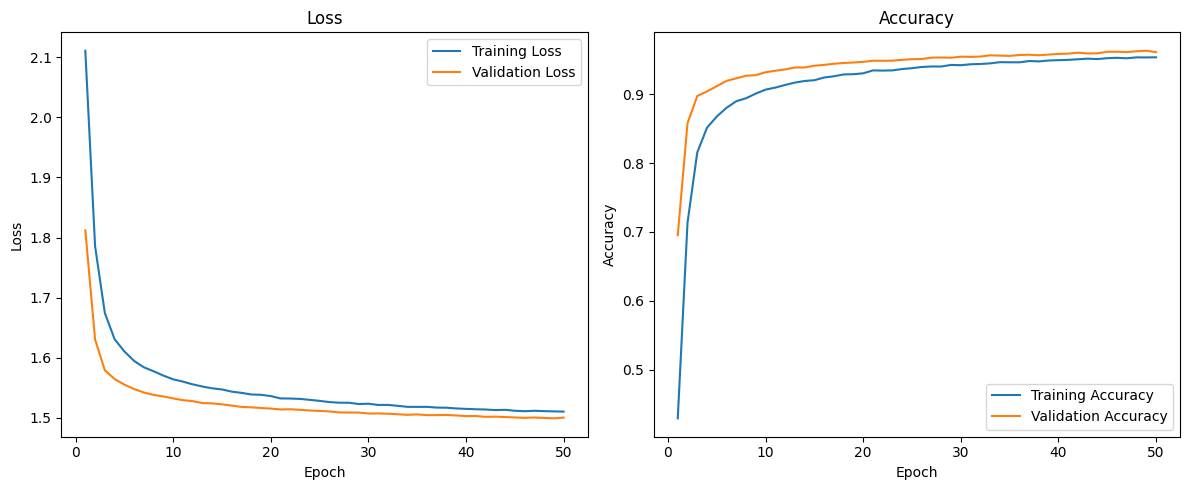

In [37]:
plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7cb1e52e3790>
Accuracy: 0.9647
Precision: 0.9647
Recall: 0.9647
F1 Score: 0.9647
Train Set: Loss: 1.4970, Accuracy: 0.9647


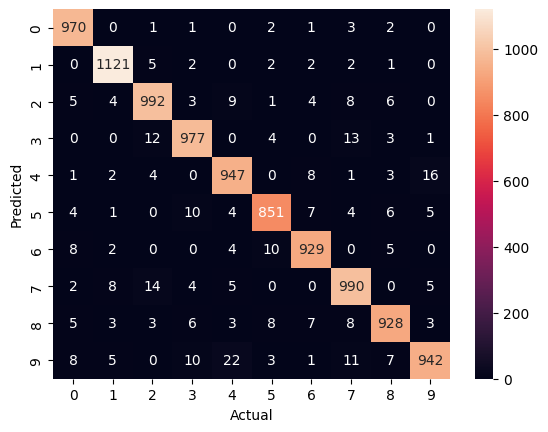

In [38]:
test_loss, test_accuracy = evaluate_classification(model, criterion, test_loader, True)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

Primetimo da je na ovaj način dobijena manja vrednost funkcije gubitka i nešto veća tačnost u odnosu na prethodni vid regularizacie.

# Analiza Prostora Gresaka

Videli smo da model daje dobru ocenu tačnosti. U praksi je značajno izdvojiti i instance na kojima model ne radi dobro u cilju boljeg razumevanja njegovog rada i budućih popravki.

Kreiraćemo prvo niz sa predikcijama modela.

In [39]:
model.eval()
predicted_labels, true_labels = [], []
device = get_device()

with torch.no_grad():  # No gradient computation during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        predicted_labels.extend(predicted.squeeze().tolist())
        true_labels.extend(labels.tolist())

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [40]:
len(predicted_labels), len(true_labels)

(10000, 10000)

Možemo nacrtati, na primer, prvih 20 instanci test skupa i obeležja koja im pridružuje klasifikator.

In [41]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
batch_idx, example_data.shape, example_targets.shape

(0, torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

In [42]:
device = get_device()
predicted_labels, true_labels = [], example_targets.tolist()

model.eval()
with torch.no_grad():
  inputs = example_data.to(device)
  outputs = model(inputs)
  predicted = torch.argmax(outputs, dim=1)
  predicted_labels.extend(predicted.squeeze().tolist())

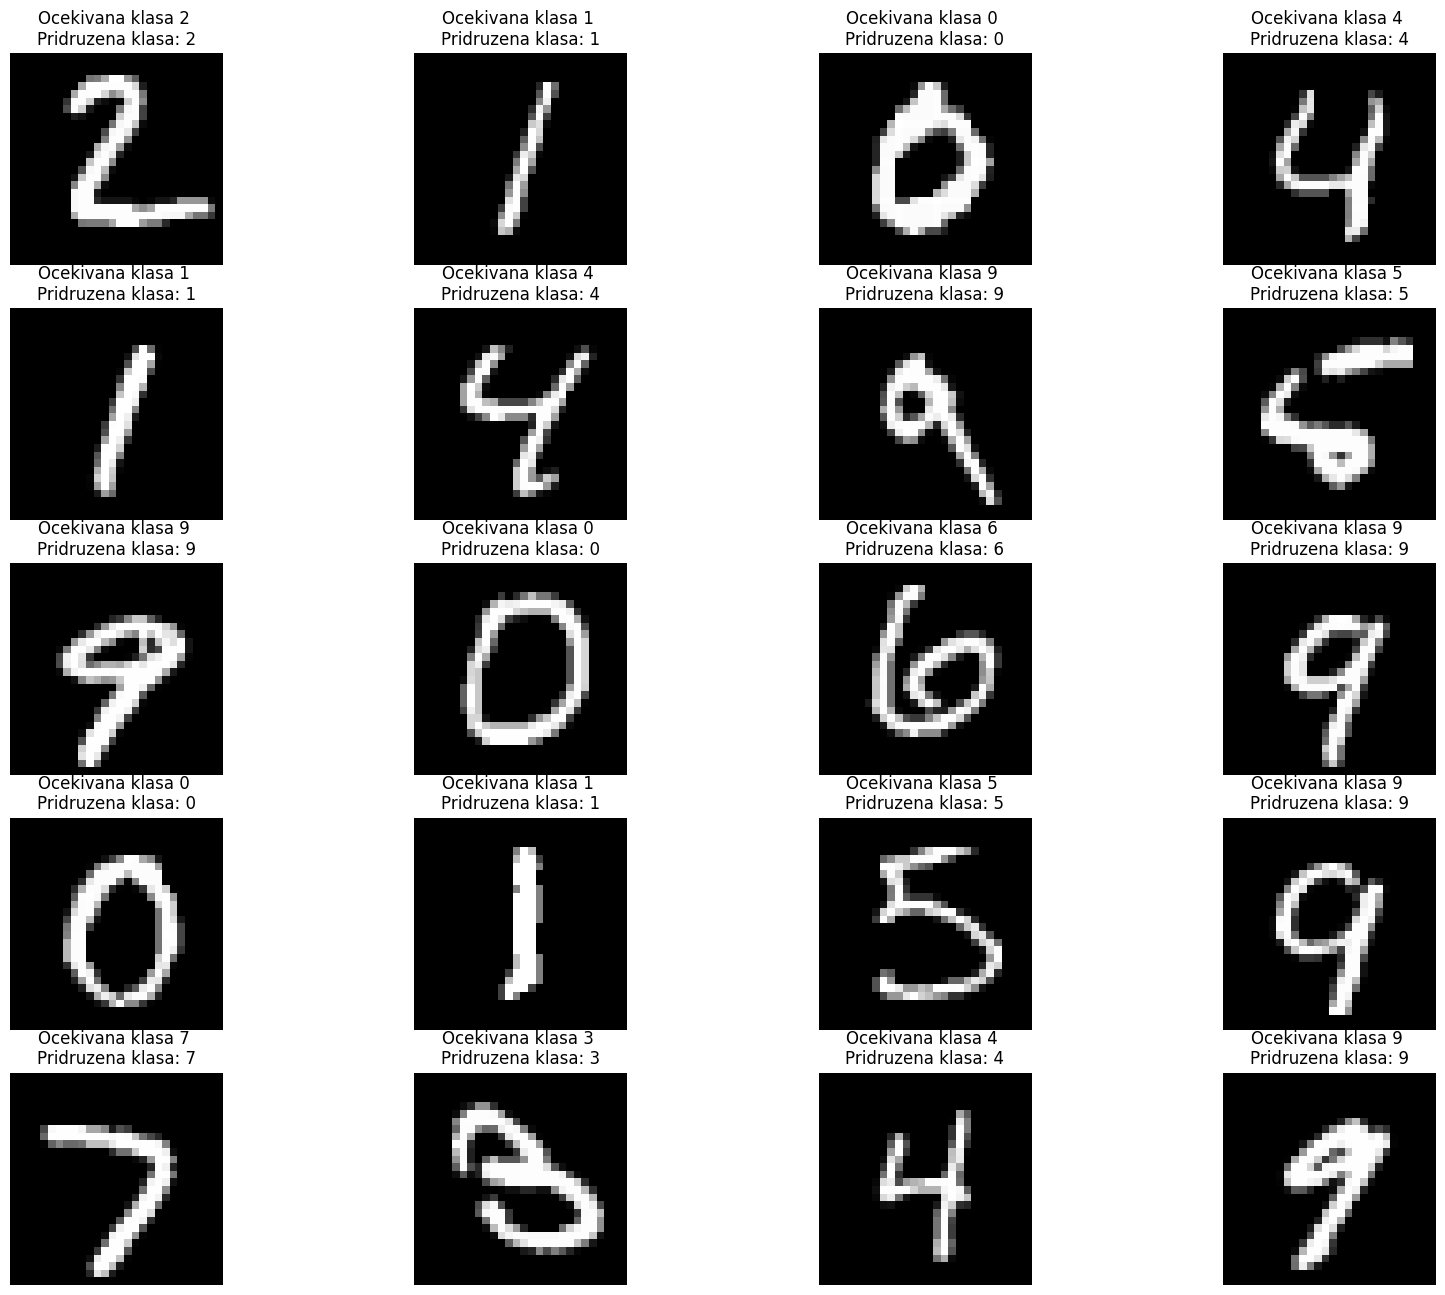

In [43]:
fig = plt.figure(figsize=(20, 16))
image_size = 28
columns = 4
rows = 5

for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)

    img = example_data[i].reshape(image_size, image_size)

    true_label, predicted_label = true_labels[i], predicted_labels[i]
    plt.title('Ocekivana klasa {} \nPridruzena klasa: {}'.format(true_label, predicted_label))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

Vidimo da su sve izdvojene slike dobro klasifikovane.